In [16]:
import os, sys, math, time, winsound, random, h5py, time, serial
import numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
# from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import model_from_json
from tensorflow.keras import layers
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import clear_output
import my_module as mm

os.makedirs("model_files", exist_ok=True)

In [22]:
def append(name):
    name_list.append(name)

# パラメータ設定

In [10]:
weight_per_depth = 0.01 ### 重みの変化量に対するdepthの変化量(1/m)
depth_per_sec = 0.005### ソレノイド開放時間に対する砂山のdepth変化量(m/sec)

In [11]:
# ser = serial.Serial("COM9", 9600)

# 初期化

## NN構築

In [12]:
x_train, y_train, x_test, y_test = mm.make_dataset(1000, 5)

In [13]:
model_initial = keras.models.Sequential([
  layers.Dense(5, activation='tanh'),
#   layers.Dense(2, activation='tanh'),
  layers.Dense(2, activation='tanh'),
  layers.Dense(2, activation='tanh')
])
predictions = model_initial(np.array(x_train)[:1]).numpy()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

3/3 [==============================] - 0s 1ms/step - loss: 0.3094 - accuracy: 0.9022


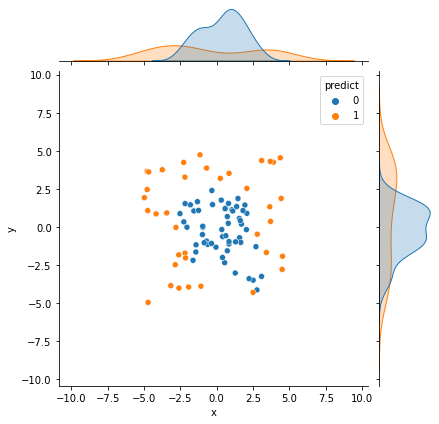

In [30]:
model_initial.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model_initial.fit(x_train, y_train, epochs=1000, verbose=0)
model_initial.evaluate(x_test, y_test)
test_result_2=pd.concat([x_test, y_test, pd.Series(np.argmax(model_initial.predict(x_test, verbose=0), axis = 1), name="predict")], axis=1)
sns.jointplot(x='x', y='y', data=test_result_2, hue="predict", marker="o")

In [31]:
model_initial.save_weights("model_files/weight.hdf5")
with open("model_files/model.json", 'w') as f:
    f.write(model_initial.to_json())

## Depth読み込み

In [32]:
initial_weight=pd.read_csv("model_files/depth_info.csv", header=None)

In [33]:
initial_weight

,0,1,2,3,4
0,0,0.000,0.000,0.000,0.000
1,0,0.000,0.000,0.264,0.241
2,0,0.000,0.000,0.000,0.430
3,0,0.000,0.000,0.421,2.358
4,0,0.477,0.412,1.917,1.996


# Loop部

## Depth読み込み

In [34]:
delta=pd.read_csv("model_files/depth_info.csv", header=None)-initial_weight
print(delta)
clear_output(wait=True)

   0    1    2    3    4
0  0  0.0  0.0  0.0  0.0
1  0  0.0  0.0  0.0  0.0
2  0  0.0  0.0  0.0  0.0
3  0  0.0  0.0  0.0  0.0
4  0  0.0  0.0  0.0  0.0


## hdf5読み込み

In [35]:
name_list=[]
data={}
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            data[name]=f[name][()]
data

{'dense/dense/bias:0': array([0.7013686, 0.3557165], dtype=float32),
 'dense/dense/kernel:0': array([[ 1.1312461 , -1.1237766 ],
        [ 0.8673079 , -0.84718114],
        [-0.8470345 ,  0.98188096],
        [-0.7519956 ,  0.6824884 ]], dtype=float32),
 'dense_1/dense_1/bias:0': array([-1.7002105, -1.7553352], dtype=float32),
 'dense_1/dense_1/kernel:0': array([[  2.351049  , -19.000711  ],
        [  2.7000768 ,  -0.11703438]], dtype=float32),
 'dense_2/dense_2/bias:0': array([-2.4945683,  2.4901593], dtype=float32),
 'dense_2/dense_2/kernel:0': array([[ 25.209835 , -25.164808 ],
        [ -5.5312343,   5.5220737]], dtype=float32)}

## 重み修正と反映

In [36]:
weight_per_depth

0.01

In [37]:
# 重み修正 係数weight_per_depth*deltaをweightへ足したり引いたり
weight_values=[]
for x in range(len(delta)):
    for y in range(len(delta.columns)):
        weight_values.append(delta.iloc[x,y]*weight_per_depth)

In [38]:
count=0
for name in data:
    print(len(data[name]), data[name])
    if len(data[name].shape)==1: # bias
        for x in range(data[name].shape[0]):
            data[name][x]=weight_values[count]
            count+=1
    elif len(data[name].shape)==2: # weight
        for x in range(data[name].shape[0]):
            for y in range(data[name].shape[1]):
                data[name][x][y]=weight_values[count]
                count+=1
print(count)

2 [0.7013686 0.3557165]
4 [[ 1.1312461  -1.1237766 ]
 [ 0.8673079  -0.84718114]
 [-0.8470345   0.98188096]
 [-0.7519956   0.6824884 ]]
2 [-1.7002105 -1.7553352]
2 [[  2.351049   -19.000711  ]
 [  2.7000768   -0.11703438]]
2 [-2.4945683  2.4901593]
2 [[ 25.209835  -25.164808 ]
 [ -5.5312343   5.5220737]]
22


In [39]:
for name in data:
    print(len(data[name]), data[name])

2 [0. 0.]
4 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
2 [0. 0.]
2 [[0. 0.]
 [0. 0.]]
2 [0. 0.]
2 [[0. 0.]
 [0. 0.]]


## 修正重みをhdf5へ反映

In [28]:
name_list=[]
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):
            if len(data[name].shape)==1: # bias
                for x in range(data[name].shape[0]):
                    data[name][x]=0
            elif len(data[name].shape)==2: # weight
                for x in range(data[name].shape[0]):
                    for y in range(data[name].shape[1]):
                        data[name][x][y]=0
            else: #?
                raise UserWarning("length>3")
            f[name][()]=data[name]
#             print(f[name][()])

## モデル再コンパイル&予測スコア出力

3/3 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5000


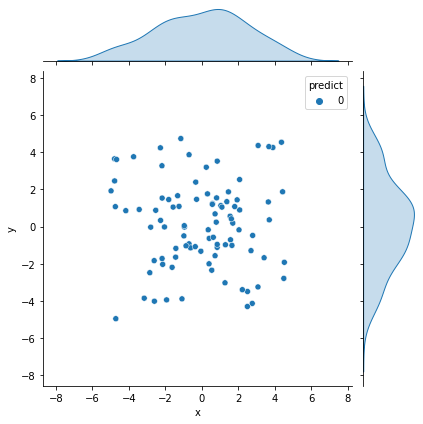

In [29]:
model=tf.keras.models.model_from_json(open("model_files/model.json", "r").read())
model.load_weights("model_files/weight.hdf5")
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model.evaluate(x_test, y_test)
test_result=pd.concat([x_test, y_test, pd.Series(np.argmax(model.predict(x_test, verbose=0), axis = 1), name="predict")], axis=1)
sns.jointplot(x='x', y='y', data=test_result, hue="predict", marker="o")

## ちょっと学習

## Arduinoへソレノイド操作の信号送信

### 学習前の重み情報を取得

In [18]:
weight_old=[]
for name in data:
#     print(len(data[name]), data[name])
    if len(data[name].shape)==1: # bias
        for x in range(data[name].shape[0]):
            weight_old.append(data[name][x])
    elif len(data[name].shape)==2: # weight
        for x in range(data[name].shape[0]):
            for y in range(data[name].shape[1]):
                weight_old.append(data[name][x][y])
print(weight_old)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 学習後の重み情報を取得

In [19]:
model.save_weights("model_files/weight.hdf5")

In [20]:
name_list=[]
data={}
with h5py.File("model_files/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            data[name]=f[name][()]

In [21]:
weight_fixed=[]
for name in data:
    if len(data[name].shape)==1: # bias
        for x in range(data[name].shape[0]):
            weight_fixed.append(data[name][x])
    elif len(data[name].shape)==2: # weight
        for x in range(data[name].shape[0]):
            for y in range(data[name].shape[1]):
                weight_fixed.append(data[name][x][y])
print(weight_fixed)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [22]:
order=[]
for i in range(len(weight_old)):
    order.append((weight_fixed[i]-weight_old[i])/weight_per_depth/depth_per_sec)

### シリアル通信

In [8]:
int(b"2200")

2200

In [ ]:
time.sleep(1) ## ? 